## Introduction

In this tutorial, we will go through a complete QEC cycle.


In [14]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

In [15]:
def encode_gate():
    encoding_circuit = QuantumCircuit(7)
    encoding_circuit.h(0)
    encoding_circuit.h(4)
    encoding_circuit.h(6)
    encoding_circuit.cx(0, 1)
    encoding_circuit.cx(4, 5)
    encoding_circuit.cx(6, 3)
    encoding_circuit.cx(4, 2)
    encoding_circuit.cx(6, 5)
    encoding_circuit.cx(0, 3)
    encoding_circuit.cx(4, 1)
    encoding_circuit.cx(3, 2)

    return encoding_circuit.to_gate(label="$U_\\text{enc}$")

In [16]:
cycle_state = {
    "iterations_remaining": 0,
    "first_flagged_syndrome": [0, 0, 0],
    "second_flagged_syndrome": [0, 0, 0],
    "unflagged_syndrome": [0, 0, 0]
}

In [17]:
def first_flagged_syndrome_circuit(cycle_state):
    l_qreg = QuantumRegister(7)
    a_qreg = QuantumRegister(3)
    m_creg = ClassicalRegister(3)
    qcirc = QuantumCircuit(l_qreg, a_qreg, m_creg)

    prev_syndrome = cycle_state["first_flagged_syndrome"]
    curr_syndrome = [0, 0, 0]

    qcirc.reset(a_qreg)

    qcirc.h(a_qreg[0])

    qcirc.cx(a_qreg[0], l_qreg[3])
    qcirc.cx(l_qreg[2], a_qreg[2])
    qcirc.cx(l_qreg[5], a_qreg[1])
    qcirc.cx(a_qreg[0], a_qreg[1])
    qcirc.cx(a_qreg[0], l_qreg[0])
    qcirc.cx(l_qreg[3], a_qreg[2])
    qcirc.cx(l_qreg[4], a_qreg[1])
    qcirc.cx(a_qreg[0], l_qreg[1])
    qcirc.cx(l_qreg[6], a_qreg[2])
    qcirc.cx(l_qreg[2], a_qreg[1])
    qcirc.cx(a_qreg[0], a_qreg[2])
    qcirc.cx(a_qreg[0], l_qreg[2])
    qcirc.cx(l_qreg[5], a_qreg[2])
    qcirc.cx(l_qreg[1], a_qreg[1])

    qcirc.h(a_qreg[0])

    for i in range(3):
        with qcirc.if_test((m_creg[i], 0)) as else_:
            curr_syndrome[i] = 0
        with else_:
            curr_syndrome[i] = 1

    if prev_syndrome == curr_syndrome:
        qcirc = qcirc.compose(second_flagged_syndrome_circuit(cycle_state), l_qreg[:] + a_qreg[:])
    else:
        cycle_state["first_flagged_syndrome"] = curr_syndrome

        qcirc = qcirc.compose(unflagged_syndrome_circuit(cycle_state), l_qreg[:] + a_qreg[:])

    return qcirc

def second_flagged_syndrome_circuit(cycle_state):
    l_qreg = QuantumRegister(7)
    a_qreg = QuantumRegister(3)
    m_creg = ClassicalRegister(3)
    qcirc = QuantumCircuit(l_qreg, a_qreg, m_creg)

    iterations_remaining = cycle_state["iterations_remaining"]
    prev_syndrome = cycle_state["second_flagged_syndrome"]
    curr_syndrome = [0, 0, 0]

    qcirc.reset(a_qreg)

    qcirc.h(a_qreg[1])
    qcirc.h(a_qreg[2])

    qcirc.cx(l_qreg[3], a_qreg[0])
    qcirc.cx(a_qreg[2], l_qreg[2])
    qcirc.cx(a_qreg[1], l_qreg[5])
    qcirc.cx(a_qreg[1], a_qreg[0])
    qcirc.cx(l_qreg[0], a_qreg[0])
    qcirc.cx(a_qreg[2], l_qreg[3])
    qcirc.cx(a_qreg[1], l_qreg[4])
    qcirc.cx(l_qreg[1], a_qreg[0])
    qcirc.cx(a_qreg[2], l_qreg[6])
    qcirc.cx(a_qreg[1], l_qreg[2])
    qcirc.cx(a_qreg[2], a_qreg[0])
    qcirc.cx(l_qreg[2], a_qreg[0])
    qcirc.cx(a_qreg[2], l_qreg[5])
    qcirc.cx(a_qreg[1], l_qreg[1])

    qcirc.h(a_qreg[1])
    qcirc.h(a_qreg[2])

    for i in range(3):
        with qcirc.if_test((m_creg[i], 0)) as else_:
            curr_syndrome[i] = 0
        with else_:
            curr_syndrome[i] = 1

    if prev_syndrome == curr_syndrome:
        if iterations_remaining > 0:
            cycle_state["iterations_remaining"] = iterations_remaining - 1

            qcirc = qcirc.compose(first_flagged_syndrome_circuit(cycle_state), l_qreg[:] + a_qreg[:])
    else:
        cycle_state["first_flagged_syndrome"] = curr_syndrome

        qcirc = qcirc.compose(unflagged_syndrome_circuit(cycle_state), l_qreg[:] + a_qreg[:])

    return qcirc

def unflagged_syndrome_circuit(cycle_state):
    l_qreg = QuantumRegister(7)
    a_qreg = QuantumRegister(3)
    m_creg = ClassicalRegister(3)
    qcirc = QuantumCircuit(l_qreg, a_qreg, m_creg)

    iterations_remaining = cycle_state["iterations_remaining"]
    curr_syndrome = [0, 0, 0]

    qcirc.reset(a_qreg)
    
    qcirc.cx(l_qreg[0], a_qreg[0])
    qcirc.cx(l_qreg[1], a_qreg[0])
    qcirc.cx(l_qreg[2], a_qreg[0])
    qcirc.cx(l_qreg[3], a_qreg[0])
    
    qcirc.cx(l_qreg[1], a_qreg[0])
    qcirc.cx(l_qreg[2], a_qreg[0])
    qcirc.cx(l_qreg[4], a_qreg[0])
    qcirc.cx(l_qreg[5], a_qreg[0])
    
    qcirc.cx(l_qreg[2], a_qreg[0])
    qcirc.cx(l_qreg[3], a_qreg[0])
    qcirc.cx(l_qreg[5], a_qreg[0])
    qcirc.cx(l_qreg[6], a_qreg[0])

    qcirc.barrier(l_qreg[:] + a_qreg[:])

    qcirc.h(a_qreg[0])
    qcirc.cx(a_qreg[1], l_qreg[0])
    qcirc.cx(a_qreg[1], l_qreg[1])
    qcirc.cx(a_qreg[1], l_qreg[2])
    qcirc.cx(a_qreg[1], l_qreg[3])
    qcirc.h(a_qreg[0])

    qcirc.h(a_qreg[1])
    qcirc.cx(a_qreg[1], l_qreg[1])
    qcirc.cx(a_qreg[1], l_qreg[2])
    qcirc.cx(a_qreg[1], l_qreg[4])
    qcirc.cx(a_qreg[1], l_qreg[5])
    qcirc.h(a_qreg[1])

    qcirc.h(a_qreg[2])
    qcirc.cx(a_qreg[1], l_qreg[2])
    qcirc.cx(a_qreg[1], l_qreg[3])
    qcirc.cx(a_qreg[1], l_qreg[5])
    qcirc.cx(a_qreg[1], l_qreg[6])
    qcirc.h(a_qreg[2])

    for i in range(3):
        with qcirc.if_test((m_creg[i], 0)) as else_:
            curr_syndrome[i] = 0
        with else_:
            curr_syndrome[i] = 1
    
    # @TODO - Decode
            
    # @TODO - Update Pauli frame and syndromes

    if iterations_remaining > 0:
        cycle_state["iterations_remaining"] = iterations_remaining - 1
        cycle_state["unflagged_syndrome"] = curr_syndrome

        qcirc = qcirc.compose(first_flagged_syndrome_circuit(cycle_state), l_qreg[:] + a_qreg[:])

    return qcirc

In [18]:
l_qreg = QuantumRegister(7)
a_qreg = QuantumRegister(3)
m_creg = ClassicalRegister(3)

qcirc = QuantumCircuit(l_qreg, a_qreg, m_creg)

In [19]:
qcirc.append(encode_gate(), l_qreg)

In [22]:
n_qec_cycles = 1
cycle_state["iterations_remaining"] = n_qec_cycles

qcirc.compose(first_flagged_syndrome_circuit(cycle_state))

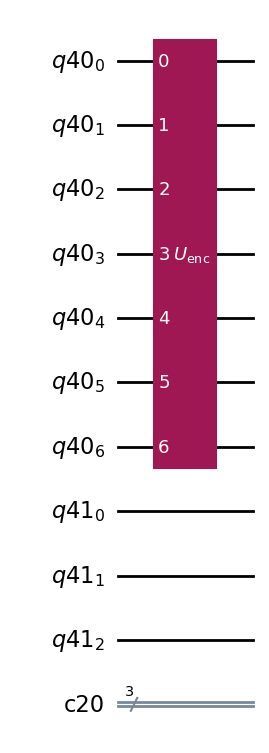

In [23]:
qcirc.draw("mpl")